# Temperature

This notebook gives a short introduction into the temperature parameter, the problems it tries to address, how it interacts with the softmax function and how to evaluate its impact.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from transformers import GPT2LMHeadModel, GPT2Tokenizer


## Summary of temperature basics.

(1) Language models sample from a probability distribution over word(piece)s.

(2) To derive such a distribution the most common way is the softmax function, with output logits $y$:  
$$ softmax = \frac{e^{y_i}}{\sum_{j=1}^n e^{y_j}} $$

(3) Softmax is a differentiable approximation of a one-hot distribution, giving disproportional weight to the highest candidate.

(4) The resulting distribution can be read as _confidence_ of a model in a given wordpiece.

(5) Neural models tend to be over-confident in their predictions, even overtaking inherent data bias.

(6) Reliable confidence values can be a useful diagnostic for handing over control to a user agent.

(7) We can modifiy the softmax function to change the impact of the exponential function on the distribution, with temperature $T$:
$$ softmax_T = \frac{e^\frac{y_i}{T}}{\sum_{j=1}^n e^\frac{y_j}{T}}$$

(8) In language models a high temperature is often correlated with more "creative" outputs, a low temperature with predictable and repetetive answers.

(9) Depending on the task, a high or low temperature might be preferable.

(10) Computational notions of confindence or surprisal are not necessarily comparable to "human" confidence.


## Exercises
This notebook consists of two short exercises that should make you familiar with modifying, implementing and evaluating different temperature and confidence values.

### Exercise 1
This exercise should make you familiar with the impact of temperature on a Large Language Model such as GPT-2. The cell below defines a text generator function that you can use, as well as instantiates the model and tokeniser.

In [48]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

def generate_text(model, tokenizer, prompt, temperature=1.0, max_length=10):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    output = model.generate(input_ids, do_sample=True, max_length=max_length, temperature=temperature)
    return tokenizer.decode(output[0], skip_special_tokens=True)

model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model.eval()

In this first exercise I want you to play around with the temperature parameter to elicit certain behaviour from the model and note the impact. For the different exercises you might need to increase the max\_length parameter, the number of generated texts or the prompt. Note down the prompt, the temperature and anything about the generated text you find interesting.

- (1.a) Make the model repeat the same text in a loop until the maximum length.  
- (1.b) Make the model produce nonsensical text. (Is it easier to produce ungrammatical or semantically incoherent text?)  
- (1.c) When do the generated texts for the same prompt produce more similar or highly dissimilar text?
- (1.d) What happens when you prompt well known text at different temperatures, e.g. the first words from Pride and Prejudice? Can you retrieve training data at a certain temperature? Why or why not?  
- (1.e) Prompt the model for gender (or any other) bias. Does temperature (as far as you can judge) have an impact on the bias exhibited?  
    Good prompts here could be something like "The woman worked as a".

In [ ]:
# Change these variables
T = 1.0  # Temperature
max_length = 50 # Maximum length of generated text, including prompt.
prompt = "All these great barns out here in the outskirts"
n_texts = 3 # Number of generated texts.

for i in range(n_texts):
    print(generate_text(model, tokenizer, prompt, temperature=T, max_length=max_length))

### Exercise 2
We will for the remainder of these exercises use the logits provided by the GPT2 model. 

- (2.a) The function below has not yet implemented the temperature parameter. How can you update the function without changing the PyTorch implementation of the softmax function?

In [12]:
def generate_probabilities(model, tokenizer, prompt, temperature=1.0):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits # raw output of a logit function (= log p/(1-p))

    probabilities = torch.softmax(logits[0, -1, :], dim=0)  # Update this function call to include temperature.

    # Get token strings and their probabilities
    tokens = [tokenizer.decode(i.item()) for i in torch.argsort(probabilities, descending=True)]
    probs = [probabilities[i].item() for i in torch.argsort(probabilities, descending=True)]
    return tokens, probs

The two cells below show the most likely wordpieces in the sequence.
- (2.b) What do you notice when you change the temperature parameter? What changes? What doesn't?

In [ ]:

prompt = "Hello, my name is"

# Tokenize input text
T = 1.0
tokens_a, probs_a = generate_probabilities(model, tokenizer, prompt, temperature=T)

T = 2.0
tokens_b, probs_b = generate_probabilities(model, tokenizer, prompt, temperature=T)

print(tokens_a)
print(tokens_b)


Below you can plot the two different distributions against each other. Note that the probabilities might be to small to be visible for high temperatures.

In [ ]:

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.barh(tokens_a[:20], probs_a[:20], color="black")
plt.barh(tokens_b[:20], probs_b[:20], color="green", alpha=0.7)
plt.xlabel('Probability')
plt.ylabel('Token')
plt.gca().invert_yaxis()
plt.show()


## Toy examples
These are two cases I wanted to include in the exercises but could not find an elegant way to incorporate them with real data (without downloading massive corpora and models), or make the programming an interesting challenge. Nonetheless I have included them here if you want to play around with visualisations.

### Reliability diagrams
Reliability diagrams are often used when looking at human confidence. It basically shows at which success rate a system (or person) has which confidence. 

In [182]:
num_samples = 1000

positive_probs = np.random.normal(loc=0.7, scale=0.1, size=num_samples)
negative_probs = np.random.normal(loc=0.3, scale=0.1, size=num_samples)

predicted_probabilities = np.concatenate([positive_probs, negative_probs])

true_labels = np.concatenate([np.random.binomial(n=1, p=p, size=num_samples) for p in [0.7, 0.3]])

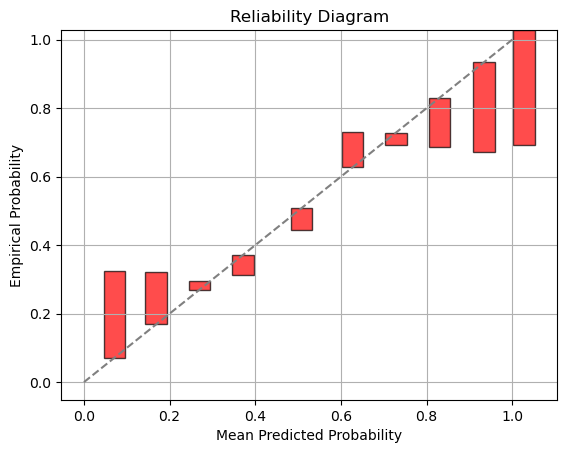

In [184]:

bins = np.linspace(0, 1, num=10)
bin_indices = np.digitize(predicted_probabilities, bins)
empirical_probabilities_dict = {}
for i in range(1, 11):
    true_label_mask = bin_indices == i
    correct_predictions = true_labels[true_label_mask]
    if len(correct_predictions) > 0:  # Check if there are instances in the bin
        empirical_prob = np.mean(correct_predictions)
        empirical_probabilities_dict[i] = empirical_prob


mean_predicted_probabilities = []
empirical_probabilities = []
for i in range(1, 11):
    bin_instances = predicted_probabilities[bin_indices == i]
    if len(bin_instances) > 0:  # Check if there are instances in the bin
        mean_prob = np.mean(bin_instances)
        mean_predicted_probabilities.append(mean_prob)
        empirical_probabilities.append(empirical_probabilities_dict.get(i, 0))  # Use default value of 0 if key not found

deviations = np.array(empirical_probabilities) - np.array(mean_predicted_probabilities)

plt.bar(mean_predicted_probabilities, deviations, 
        bottom=mean_predicted_probabilities, width=0.05, color='red', alpha=0.7, align='center', edgecolor='black')# Plot the reliability diagram
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Ideal line
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Empirical Probability')
plt.title('Reliability Diagram')
plt.grid(True)
plt.show()


### Animated temperature
This is just a short script that creates a gif of the effect of temperature on random data. 

In [4]:
data = torch.tensor(torch.randn(20))

def update(frame):
    T = frame
    plt.cla()  # Clear the current axis
    scaled_data = data / T
    softmax_values = torch.softmax(scaled_data, dim=0)
    plt.bar(range(len(softmax_values)), softmax_values)
    plt.title('Softmax Applied to Logits (T={:.1f})'.format(float(frame)))
    plt.xlabel('Class')
    plt.ylabel('Softmax Output')
    plt.xticks(range(len(softmax_values)), labels=range(len(softmax_values)))
    plt.grid(True)

fig = plt.figure()

ani = animation.FuncAnimation(fig, update, frames=torch.linspace(0.1, 5, 50), interval=200)

ani.save('softmax_animation.gif', writer='imagemagick')
plt.close()

/tmp/ipykernel_12782/1968397096.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(torch.randn(20))
MovieWriter imagemagick unavailable; using Pillow instead.


![softmax animation](softmax_animation.gif)